In [2]:
import gensim
import spacy
from collections import defaultdict
import pathlib
import spacy
nlp = spacy.load('en_core_web_md')

In [3]:
#Adding the documents from sci.space topic
corpus1 = []
for path in pathlib.Path("20news-bydate/20news-bydate-train/sci.space").iterdir():
    if path.is_file():
        current_file = open(path, "r")
        corpus1.append(current_file.read())
        current_file.close()
        

In [4]:
#Adding the documents from talk.politics topic
corpus2 = []
for path in pathlib.Path("20news-bydate/20news-bydate-train/talk.politics.guns").iterdir():
    if path.is_file():
        current_file = open(path, "r", encoding = "ISO-8859-1")
        corpus2.append(current_file.read())
        current_file.close()

In [5]:
#Adding the documents from rec.autos document
corpus3 = []
for path in pathlib.Path("20news-bydate/20news-bydate-train/rec.autos").iterdir():
    if path.is_file():
        current_file = open(path, "r", encoding = "ISO-8859-1")
        corpus3.append(current_file.read())
        current_file.close()

In [6]:
#Methods to clean documents, remove stopwords, numerical values, punctuation
from nltk.corpus import stopwords
def keep_token(t):
    return (t.is_alpha and 
            not (t.is_space or t.is_punct or 
                 t.is_stop or t.like_num))

def lemmatize_doc(doc):
    return [t.lemma_ for t in doc if keep_token(t)]

In [7]:
#Cleaning all of the documents in each topic
corpus1 = [lemmatize_doc(nlp(doc)) for doc in corpus1]
corpus2 = [lemmatize_doc(nlp(doc)) for doc in corpus2]
corpus3 = [lemmatize_doc(nlp(doc)) for doc in corpus3]

In [8]:
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
import numpy as np
print(corpus1)

[['Gregory', 'Bond', 'subject', 'year', 'long', 'moon', 'resident', 'reply', 'message', 'Sun', 'Apr', 'GMT', 'nntp', 'posting', 'Host', 'leo', 'gw', 'organization', 'Burdett', 'Buckeridge', 'Young', 'Melbourne', 'Australia', 'line', 'article', 'Gene', 'Wright', 'write', 'announce', 'reward', 'corporation', 'successfully', 'keep', 'person', 'alive', 'moon', 'year', 'offer', 'problem', 'keep', 'alive', 'highly', 'likely', 'involve', 'lunar', 'environment', 'oh', 'dear', 'freighter', 'land', 'roof', 'ACME', 'base', 'die', 'sad', 'Gosh', 'leave', 'old', 'resident', 'Quick', 'Boss', 'slime', 'YoyoDyne', 'time', 'get', 'tank', 'man', 'gun', 'imagine', 'sort', 'technology', 'develop', 'sort', 'environment', 'Greg', 'kid', 'btw', 'problem', 'winner', 'take', 'prize', 'encourage', 'sort', 'undesirable', 'behaviour', 'witness', 'military', 'procurement', 'program', 'probably', 'far', 'small', 'reward', 'encourage', 'expensive', 'high', 'risk', 'proposition', 'Gregory', 'Bond', 'Burdett', 'Bucker

In [8]:
#Adding all documents into one big corpus list
new_corpus1 = []
for doc in corpus1:
    new_corpus1.append(doc)
    
for doc in corpus2:
    new_corpus1.append(doc)
    
for doc in corpus3:
    new_corpus1.append(doc)
#Filtering out words that are too common or infrequent across all documents
docs_dict = Dictionary(new_corpus1)
docs_dict.filter_extremes(no_below=20, no_above=0.2)
docs_dict.compactify()

#Creating a bag-of-wrds model from all of the documents within the corpus
bag_of_words = [docs_dict.doc2bow(line) for line in new_corpus1]
model = TfidfModel(bag_of_words) 

#Adding the tf-idf results of the words in each document into a list
vector = []
for doc in bag_of_words:
    vector.append(model[doc])

In [9]:
from gensim.models import Word2Vec

In [10]:
#Running word2vec to get word embeddings for each word in each of the documents
word2vec = Word2Vec(new_corpus1, window = 6, min_count=5, iter=1000, size = 300)
vocabulary = word2vec.wv.vocab

In [11]:
#Creating weighted tf-idf word embeddings for each word in each document and averaging the word embeddings for each
#document to create an overall document embedding
embed_tfidf = np.array([])
out_count = 0
for vec in vector:
    sum_vec = np.array([])
    count_vals = 0
    for (id_num, val) in vec:
        if docs_dict[id_num] in word2vec:
            weighted_val = np.array([])
            #Creating weighted tf-idf word embeddings by multiplying each word embedding vector with the word's tf-idf
            #value
            weighted_val = np.append(weighted_val, val * np.array(word2vec[docs_dict[id_num]]))
            if count_vals is 0:
                sum_vec = np.append(sum_vec, weighted_val)
            else:
                sum_vec += weighted_val
            count_vals += 1
    #Averaging the word embeddings in each document to create an overall document embedding
    doc_avg = sum_vec / count_vals
    if out_count is 0:
        embed_tfidf = np.array([doc_avg])
    else:
        embed_tfidf = np.append(embed_tfidf, np.array([doc_avg]), axis=0)
    out_count += 1

/Users/sanketmanjesh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if __name__ == '__main__':
/Users/sanketmanjesh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


In [12]:
#Reduce dimensinality of results to plot
from sklearn.decomposition import PCA
docs_pca = PCA(n_components=8).fit_transform(embed_tfidf)

In [13]:
from sklearn import manifold
#Create 2-D coordinates for each point to visualize
tsne = manifold.TSNE()
viz = tsne.fit_transform(docs_pca)

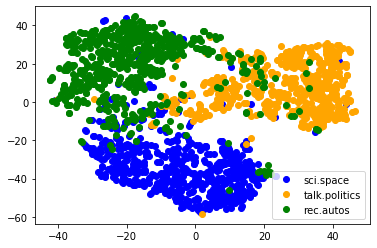

In [17]:
import matplotlib.pyplot as plt
#Results showing the seperation of documents my model was able to create based on the three overall topics each 
#document fell into
fig, axs = plt.subplots()
first_ind = np.array([], dtype=int)
second_ind = np.array([], dtype=int)
third_ind = np.array([], dtype=int)
for i in range(0, 593):
    first_ind = np.append(first_ind, int(i))
for i in range(593, 1139):
    second_ind = np.append(second_ind, int(i))
for i in range(1139, 1733):
    third_ind = np.append(third_ind, int(i))
axs.plot(viz[first_ind, 0], viz[first_ind, 1], color = "blue", marker='o', linestyle='', label='sci.space')
axs.plot(viz[second_ind, 0], viz[second_ind, 1], color = "orange", marker='o', linestyle='', label='talk.politics')
axs.plot(viz[third_ind, 0], viz[third_ind, 1], color = "green", marker='o', linestyle='',label='rec.autos')
axs.legend()
plt.show()